# Airbnb Rio de Janeiro — Price Optimization (XGBoost)

**Colab-ready notebook** — Advanced EDA, preprocessing pipeline, XGBoost model, and hyperparameter tuning (GridSearchCV).  
**Notes:** This notebook expects `listings.csv` to be present in the Colab working directory (or `/mnt/data` here).  
Target variable `price` will be log-transformed. The final tuned model will be evaluated and visualized.


## 1. Install & Imports

Run the following cell to install required packages (if not already present on Colab).

In [1]:
!pip install xgboost --quiet
!pip install category_encoders --quiet

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import category_encoders as ce

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


## 2. Load dataset

Load the dataset from the working directory. Verify its shape and head.

In [2]:
df = pd.read_csv('listings.csv')
print('Shape:', df.shape)
df.head()


Shape: (42572, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,17878,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",68997,Matthias,NaN,Copacabana,-22.96599,-43.17940,Entire home/apt,254.0,5,338,2025-06-25,1.86,1,225,19,NaN
1,25026,Beautiful Modern Decorated Studio in Copacabana,102840,Viviane,NaN,Copacabana,-22.97649,-43.19122,Entire home/apt,252.0,2,313,2025-06-23,1.71,1,193,23,NaN
2,35764,COPACABANA SEA BREEZE - RIO - 25 X Superhost,153691,Patricia Miranda & Paulo,NaN,Copacabana,-22.98107,-43.19136,Entire home/apt,190.0,3,516,2025-06-05,2.88,1,103,41,NaN
3,48305,Bright 6bed Penthouse Seconds from Beach,70933,Goitaca,NaN,Ipanema,-22.98591,-43.20302,Entire home/apt,2239.0,7,183,2025-02-25,1.05,6,351,5,NaN
4,48901,Extra large 4BD 3BT on the AtlanticAve. Copaca...,222884,Marcio,NaN,Copacabana,-22.96574,-43.17514,Entire home/apt,743.0,3,48,2025-06-13,0.40,1,311,17,NaN


### 2.1 Quick info & null counts

In [3]:
df.info()
print('\nMissing values per column:')
(df.isnull().sum().sort_values(ascending=False).head(50))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42572 entries, 0 to 42571
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42572 non-null  int64  
 1   name                            42572 non-null  object 
 2   host_id                         42572 non-null  int64  
 3   host_name                       41092 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   42572 non-null  object 
 6   latitude                        42572 non-null  float64
 7   longitude                       42572 non-null  float64
 8   room_type                       42572 non-null  object 
 9   price                           38992 non-null  float64
 10  minimum_nights                  42572 non-null  int64  
 11  number_of_reviews               42572 non-null  int64  
 12  last_review                     

,0
license,42572
neighbourhood_group,42572
reviews_per_month,8623
last_review,8623
price,3580
host_name,1480
name,0
id,0
neighbourhood,0
host_id,0


## 3. Target analysis — `price`

Check price distribution, outliers, and apply log transform planning.

count     38992.000000
mean        688.009463
std        3758.454763
min          34.000000
25%         200.000000
50%         311.000000
75%         558.000000
max      500000.000000
Name: price, dtype: float64


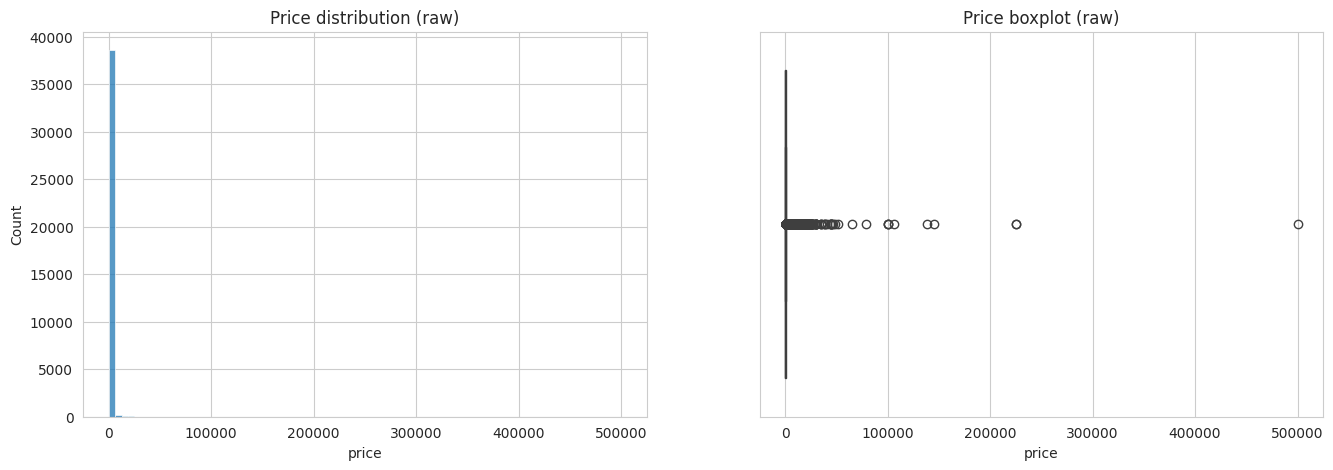

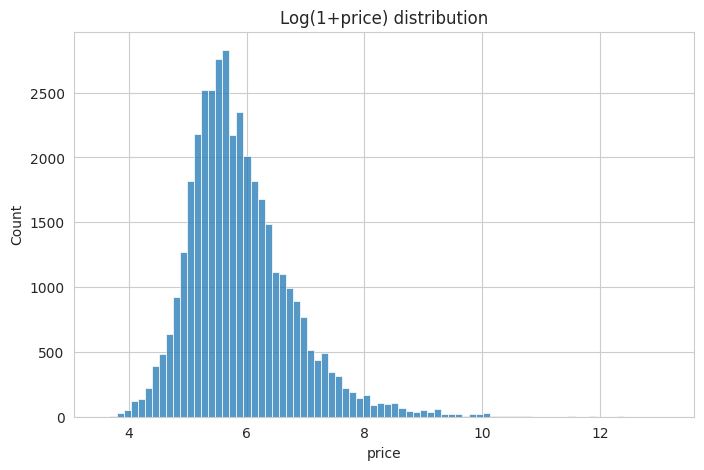

In [4]:
# Clean price column (remove currency symbols if needed)
# Some listings include '$' or commas; ensure numeric
if df['price'].dtype == object:
    df['price'] = df['price'].astype(str).str.replace('[\$,]', '', regex=True).str.replace(',', '').astype(float)

# Basic stats
print(df['price'].describe())

# Histogram and boxplot
fig, axes = plt.subplots(1,2, figsize=(16,5))
sns.histplot(df['price'].dropna(), bins=80, ax=axes[0])
axes[0].set_title('Price distribution (raw)')

sns.boxplot(x=df['price'].dropna(), ax=axes[1])
axes[1].set_title('Price boxplot (raw)')
plt.show()

# Log transform view
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.histplot(np.log1p(df['price'].dropna()), bins=80)
ax.set_title('Log(1+price) distribution')
plt.show()


## 4. Advanced EDA

Explore neighbourhood pricing, reviews, availability, and feature correlations.

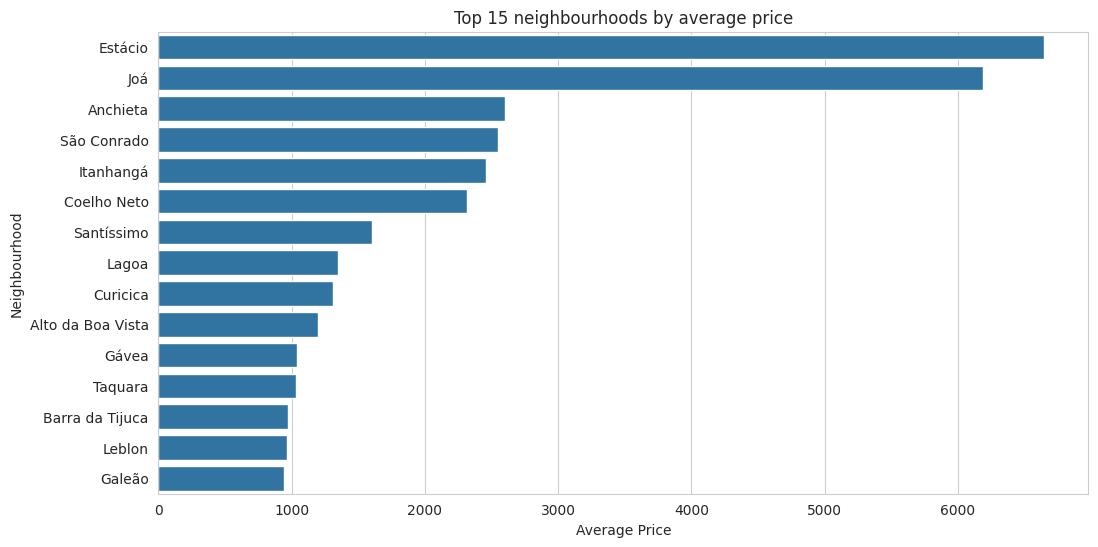

In [5]:
# Top 15 neighbourhoods by average price
nbhd_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(15)
nbhd_price = nbhd_price.reset_index()
nbhd_price

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=nbhd_price, x='price', y='neighbourhood')
plt.title('Top 15 neighbourhoods by average price')
plt.xlabel('Average Price')
plt.ylabel('Neighbourhood')
plt.show()


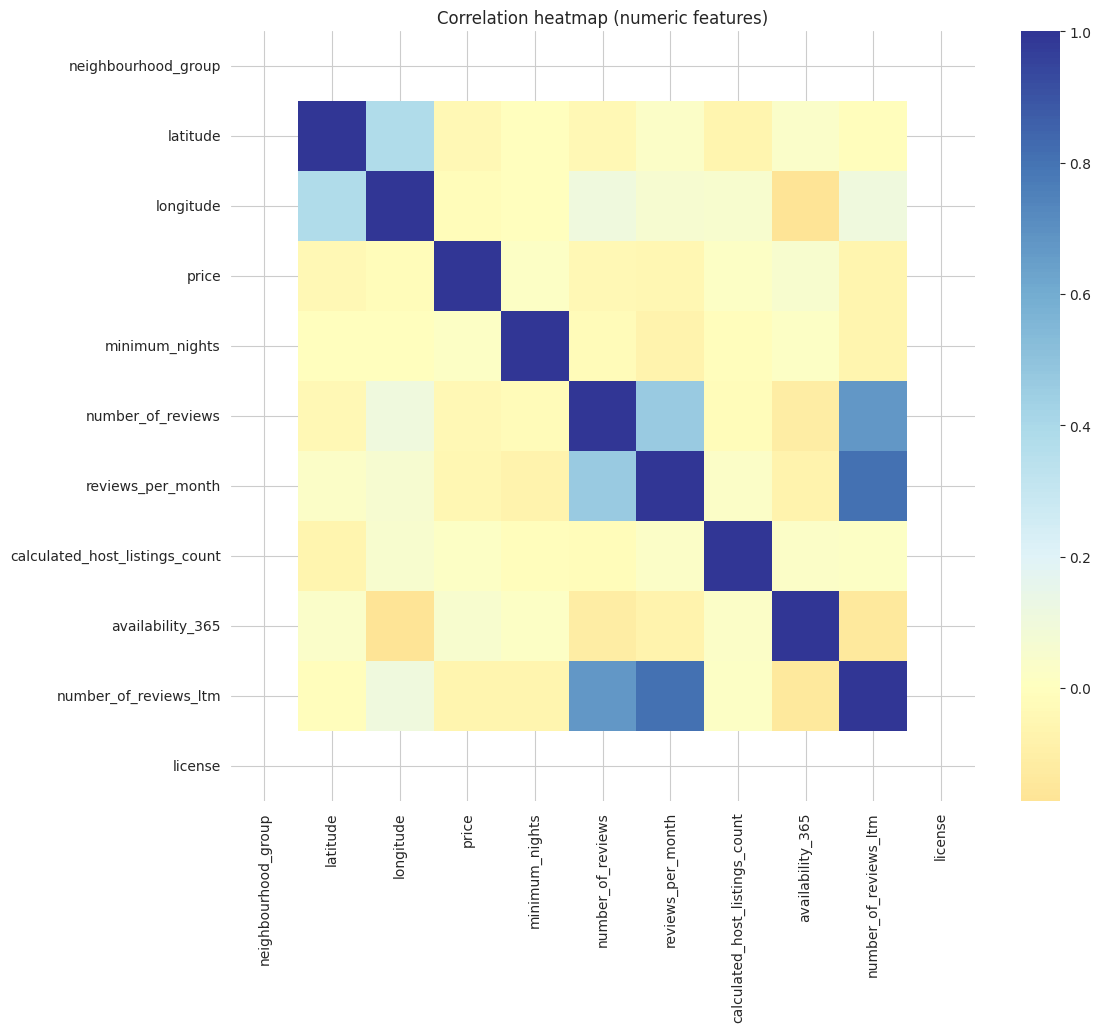

In [6]:
# Correlation heatmap for numeric features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# limit to sensible numeric columns
num_cols = [c for c in num_cols if c not in ['id','host_id']][:30]

corr = df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='RdYlBu', center=0)
plt.title('Correlation heatmap (numeric features)')
plt.show()


## 5. Missing values strategy

We will impute numeric columns with the median and categorical columns with 'Unknown'.
We will also combine rare categories into 'Other' for high-cardinality features (like neighbourhood).

In [8]:
df_prep = df_fe.copy()
# Identify categorical and numeric
cat_cols = df_prep.select_dtypes(include=['object']).columns.tolist()
num_cols = df_prep.select_dtypes(include=['int64','float64']).columns.tolist()
# Remove identifier-like columns if present
for x in ['id','host_id']:
    if x in num_cols:
        num_cols.remove(x)

print('Numeric cols:', len(num_cols), 'Categorical cols:', len(cat_cols))

# Combine rare categories for neighbourhood (keep top 20)
if 'neighbourhood' in df_prep.columns:
    topn = df_prep['neighbourhood'].value_counts().nlargest(20).index
    df_prep['neighbourhood'] = df_prep['neighbourhood'].apply(lambda x: x if x in topn else 'Other')

# Quick fill
for c in num_cols:
    df_prep[c] = df_prep[c].fillna(df_prep[c].median())
for c in cat_cols:
    df_prep[c] = df_prep[c].fillna('Unknown')

# Verify no nulls remain in selected columns
print(df_prep[num_cols].isnull().sum().sum(), df_prep[cat_cols].isnull().sum().sum())


Numeric cols: 12 Categorical cols: 5
85144 0


## 6
. Prepare X, y and Train-Test split

We will log-transform the target and split the data.

In [9]:
# Select features (drop text-heavy columns and IDs)
exclude = ['id','listing_url','name','summary','space','description','neighborhood_overview','host_name','host_about','host_location','host_response_time','host_thumbnail_url','host_picture_url','host_listings_count','host_verifications','host_neighbourhood']
features = [c for c in df_prep.columns if c not in exclude and c != 'price']

X = df_prep[features].copy()
y = np.log1p(df_prep['price'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)


X_train shape: (34057, 15) X_test shape: (8515, 15)


## 7. Preprocessing pipeline

Numeric: median imputer + StandardScaler.  
Categorical: combine rare handled earlier, then OneHotEncoder(handle_unknown='ignore').

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print('Numeric features:', len(numeric_features))
print('Categorical features:', len(categorical_features))


Numeric features: 12
Categorical features: 3


## 8. Baseline model — Linear Regression

Build a quick baseline to compare later with XGBoost.

In [11]:
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)

# inverse transform predictions
y_pred_baseline_orig = np.expm1(y_pred_baseline)
y_test_orig = np.expm1(y_test)

print('Baseline R2:', r2_score(y_test_orig, y_pred_baseline_orig))
print('Baseline MSE:', mean_squared_error(y_test_orig, y_pred_baseline_orig))
print('Baseline RMSE:', np.sqrt(mean_squared_error(y_test_orig, y_pred_baseline_orig)))


Baseline R2: -0.023022736867188476
Baseline MSE: 12370776.585022287
Baseline RMSE: 3517.2114785753624


## 9. XGBoost model — quick run

Train a baseline XGBoost regressor with reasonable defaults.

In [12]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb_log = xgb_pipeline.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)

print('XGB R2:', r2_score(y_test_orig, y_pred_xgb))
print('XGB MSE:', mean_squared_error(y_test_orig, y_pred_xgb))
print('XGB RMSE:', np.sqrt(mean_squared_error(y_test_orig, y_pred_xgb)))


XGB R2: 0.03595380759032707
XGB MSE: 11657609.976942027
XGB RMSE: 3414.324234302013


### 9.1 Cross-validated R² (quick 5-fold)

In [13]:
cv_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)
print('CV R2 scores:', cv_scores)
print('Mean CV R2:', cv_scores.mean())


CV R2 scores: [0.40996023 0.45691644 0.45416903 0.44728704 0.3005784 ]
Mean CV R2: 0.41378222826185435


## 10. Hyperparameter tuning — GridSearchCV (XGBoost)

This search can be time-consuming. Adjust param grid if runtime is a concern.

In [14]:
param_grid = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 6],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

grid = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV R2:', grid.best_score_)

best_model = grid.best_estimator_
y_pred_grid = np.expm1(best_model.predict(X_test))
print('Tuned XGB R2:', r2_score(y_test_orig, y_pred_grid))
print('Tuned XGB RMSE:', np.sqrt(mean_squared_error(y_test_orig, y_pred_grid)))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV R2: 0.4608477158886106
Tuned XGB R2: 0.03595380759032707
Tuned XGB RMSE: 3414.324234302013


## 11. Residual analysis & conclusions

Plot predicted vs actual and residuals. Then summarize next steps.

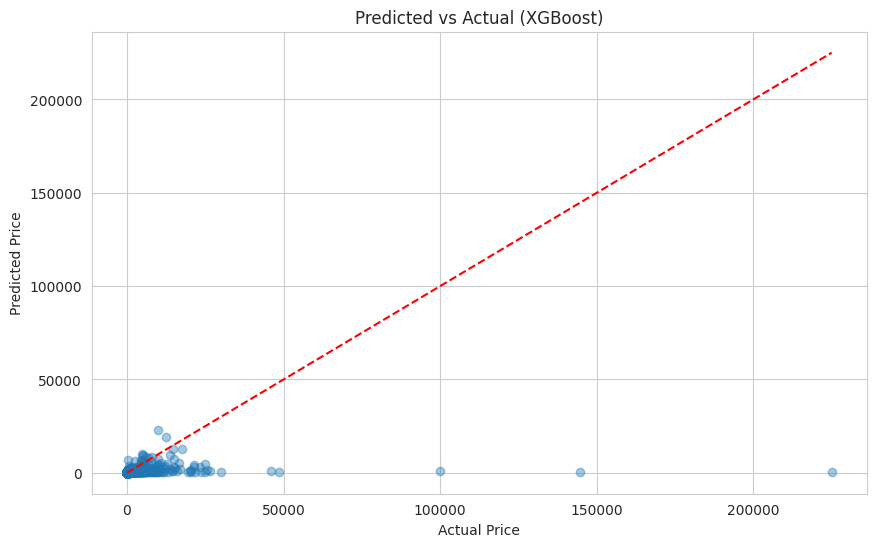

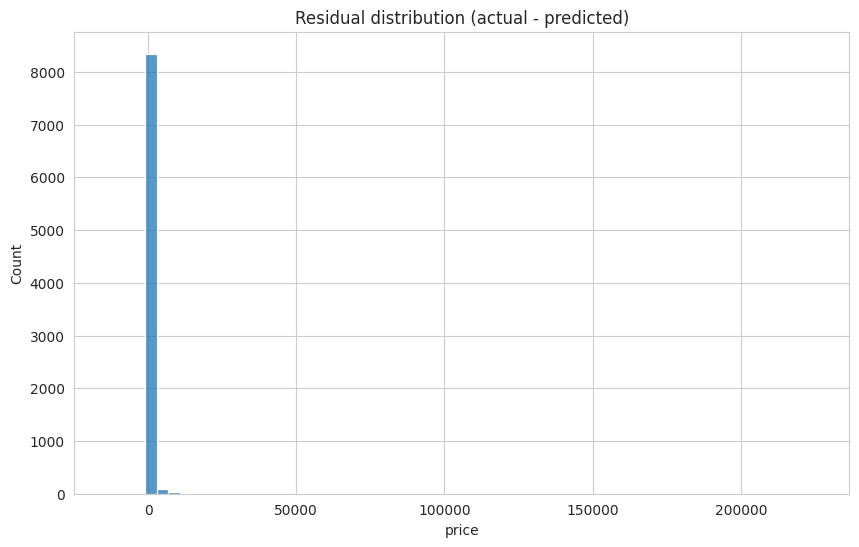

Next steps suggestions:
- Tune hyperparameters further or use RandomizedSearchCV / Optuna
- Add more feature engineering (temporal features, demand proxies)
- Consider target trimming or robust loss if many outliers exist


In [16]:
# Predicted vs actual
plt.scatter(y_test_orig, y_pred_xgb, alpha=0.4)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual (XGBoost)')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.show()

# Residuals
resid = y_test_orig - y_pred_xgb
sns.histplot(resid, bins=60)
plt.title('Residual distribution (actual - predicted)')
plt.show()

print('Next steps suggestions:')
print('- Tune hyperparameters further or use RandomizedSearchCV / Optuna')
print('- Add more feature engineering (temporal features, demand proxies)')
print('- Consider target trimming or robust loss if many outliers exist')
